In [11]:
!pip install Sastrawi

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns

In [13]:
df = pd.read_csv("/content/dataset_chatgpt_100_pos_100_neg_50_net.csv")
df = df.dropna()

print("Jumlah data:", len(df))
df.head()


Jumlah data: 250


,content,clean,sentimen
0,"kok lemot bgt yaaa skrg, pas kirim pesan ga di...",kok lemot bgt yaaa skrg pas kirim pesan ga dib...,Negatif
1,mantap,mantap,Positif
2,omg bagus sekali,omg bagus sekali,Positif
3,bagus,bagus,Positif
4,membatu soal yang susah,membatu soal yang susah,Negatif


In [14]:
# Inisialisasi stemmer
stem_factory = StemmerFactory()
indo_stemmer = stem_factory.create_stemmer()

# Stopword handling
try:
    indo_stopwords = set(stopwords.words('indonesian'))
except:
    indo_stopwords = set([
        "yang", "dan", "di", "ke", "dari", "untuk", "pada",
        "dengan", "oleh", "sebagai", "adalah", "itu",
        "ini", "akan", "juga", "karena"
    ])

def text_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in indo_stopwords]
    tokens = [indo_stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Terapkan preprocessing
df["hasil_stemming"] = df["clean"].apply(text_preprocess)

print(df[["clean", "hasil_stemming"]].head(10))

                                               clean  \
0  kok lemot bgt yaaa skrg pas kirim pesan ga dib...   
1                                             mantap   
2                                   omg bagus sekali   
3                                              bagus   
4                            membatu soal yang susah   
5                                              jelek   
6  sekarang sangat jelek sudah langganan cuma sur...   
7                                      jelek pokonya   
8                                              bagus   
9                                              jelek   

                                      hasil_stemming  
0  kok lot bgt yaaa skrg pas kirim pesan ga dibal...  
1                                             mantap  
2                                   omg bagus sekali  
3                                              bagus  
4                                    batu soal susah  
5                                              jelek 

In [15]:
tfidf_vector = TfidfVectorizer(
    max_features=1200,
    min_df=2,
    max_df=0.85
)

X = tfidf_vector.fit_transform(df["hasil_stemming"])

In [16]:
range_n_clusters = range(2, 8)
scores = []

for k in range_n_clusters:
    model = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

best_k = list(range_n_clusters)[np.argmax(scores)]
print(f"K optimal berdasarkan Silhouette Score: {best_k}")

K optimal berdasarkan Silhouette Score: 7


In [17]:
kmeans_final = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init=10
)

df["cluster"] = kmeans_final.fit_predict(X)

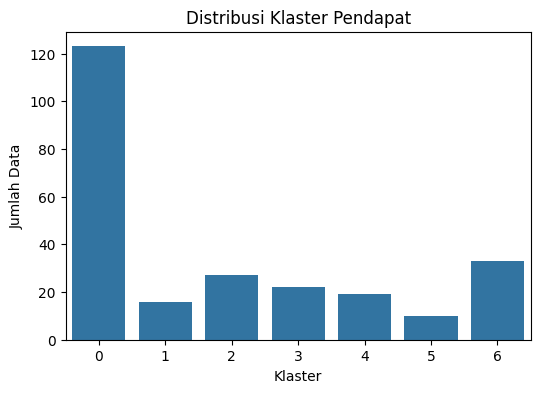

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(
    x="cluster",
    data=df
)
plt.title("Distribusi Klaster Pendapat")
plt.xlabel("Klaster")
plt.ylabel("Jumlah Data")
plt.show()

Inertia (WCSS) per k:
    k     Inertia
0   1  230.022001
1   2  211.579727
2   3  201.855347
3   4  195.169855
4   5  189.500584
5   6  186.481166
6   7  176.489526
7   8  173.407825
8   9  167.294485
9  10  165.677085


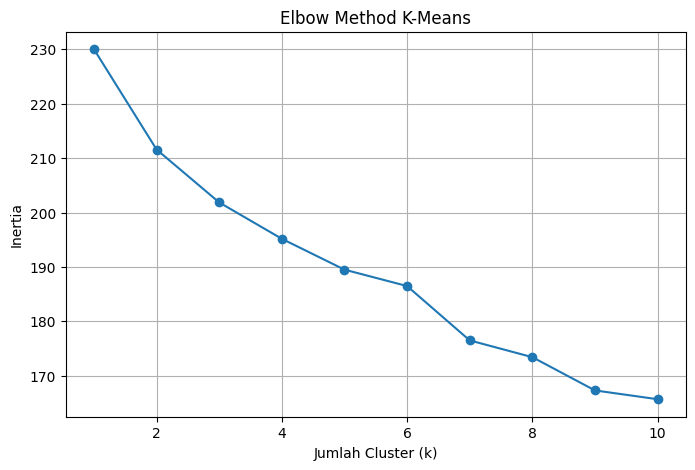

Optimal k = 3
Inertia pada k optimal = 201.85534666678242


In [19]:
inertia_scores = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X)
    inertia_scores.append(km.inertia_)

# Titik garis awal & akhir
x_start, y_start = 1, inertia_scores[0]
x_end, y_end = K_range[-1], inertia_scores[-1]

jarak = []
for k, inertia in zip(K_range, inertia_scores):
    d = abs(
        (y_end - y_start)*k -
        (x_end - x_start)*inertia +
        x_end*y_start -
        y_end*x_start
    ) / np.sqrt((y_end - y_start)**2 + (x_end - x_start)**2)
    jarak.append(d)

optimal_k = K_range[np.argmax(jarak)]
optimal_inertia = inertia_scores[optimal_k - 1]

# Tabel inertia
tabel_inertia = pd.DataFrame({
    "k": list(K_range),
    "Inertia": inertia_scores
})

print("Inertia (WCSS) per k:")
print(tabel_inertia)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia_scores, marker='o')
plt.title("Elbow Method K-Means")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

print("Optimal k =", optimal_k)
print("Inertia pada k optimal =", optimal_inertia)

In [20]:
print("\nPerbandingan Cluster dengan Sentimen Asli:")
print(pd.crosstab(df["sentimen"], df["cluster"]))


Perbandingan Cluster dengan Sentimen Asli:
cluster    0   1   2   3   4   5   6
sentimen                            
Negatif   29  16   0   5  17   0  33
Netral    39   0   0  10   1   0   0
Positif   55   0  27   7   1  10   0
